In [1]:
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pywt
import pywt.data

In [2]:
from skimage import data, exposure, io
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel,threshold_local

In [3]:
from astropy.convolution import MexicanHat2DKernel, convolve

In [4]:
img = io.imread("data/Iba1_10x.jpg")
grayscale = rgb2gray(img)
grayscale_eq = exposure.equalize_hist(grayscale)

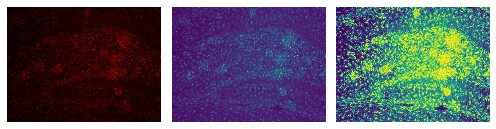

In [5]:
fig = plt.figure(figsize=(7, 3))

fig.add_subplot(1, 3, 1)
plt.imshow(img, interpolation='nearest')
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(grayscale, interpolation='nearest')
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_eq, interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
img = cv2.imread('data/Iba1_10x.jpg')
b,g,r = cv2.split (img)
cv2.imshow('Blue Channel',b)
cv2.imshow('Green Channel',g)
cv2.imshow('Red Channel',r)
cv2.waitKey(0)
cv2.destroyAllWindows()

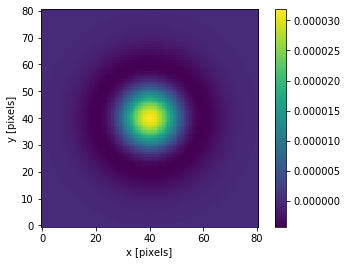

In [10]:
mexicanhat_2D_kernel = MexicanHat2DKernel(10)
plt.imshow(mexicanhat_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

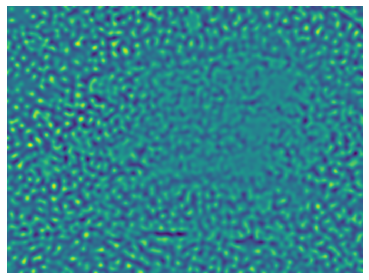

In [15]:
img_convoluted = convolve(grayscale_eq, mexicanhat_2D_kernel, boundary='extend', fill_value=0.0, nan_treatment='fill', normalize_kernel=False, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
plt.imshow(img_convoluted, interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
from numpy import (arange, ceil, concatenate, conjugate, cos, exp, floor, 
                   isnan, log, log2, meshgrid, ones, pi, prod, real, sqrt,
                   zeros, polyval)
from numpy.fft import fft2, ifft2, fftfreq


class Mexican_hat():
    """Implements the Mexican hat wavelet class."""

    name = 'Mexican hat'
    
    def __init__(self):
        # Reconstruction factor $C_{\psi, \delta}$
        self.cpsi = 1. # pi

    def psi_ft(self, k, l):
        """
        Fourier transform of the Mexican hat wavelet as in Wang and
        Lu (2010), equation [15].
 
        """
        K, L = meshgrid(k, l)
        return (K ** 2. + L ** 2.) * exp(-0.5 * (K ** 2. + L ** 2.))

    def psi(self, x, y):
        """Mexican hat wavelet as in Wang and Lu (2010), equation [14]."""
        X, Y = meshgrid(x, y)
        return (2. - (X ** 2. + Y ** 2.)) * exp(-0.5 * (X ** 2. + Y ** 2.))


def cwt2d(f, dx, dy, a=None, wavelet=Mexican_hat()):
    """
    Bi-dimensional continuous wavelet transform of the signal at 
    specified scale a.
    PARAMETERS
        f (array like):
            Input signal array.
        dx, dy (float):
            Sample spacing for each dimension.
        a (array like, optional):
            Scale parameter array.
        wavelet (class, optional) :
            Mother wavelet class. Default is Mexican_hat()
    RETURNS
    EXAMPLE
    """
    # Determines the shape of the arrays and the discrete scales.
    n0, m0 = f.shape
    N, M = 2 ** int(ceil(log2(n0))), 2 ** int(ceil(log2(m0)))
    if a == None:
        a = 2 ** arange(int(floor(log2(min(n0, m0)))))
    A = len(a)
    # Calculates the zonal and meridional wave numbers.
    l, k = fftfreq(N, dy), fftfreq(M, dx)
    # Calculates the Fourier transform of the input signal.
    f_ft = fft2(f, s=(N, M))
    # Creates empty wavelet transform array and fills it for every discrete
    # scale using the convolution theorem.
    Wf = zeros((A, N, M), 'complex')
    for i, an in enumerate(a):
        psi_ft_bar = an * wavelet.psi_ft(an * k, an * l)
        Wf[i, :, :] = ifft2(f_ft * psi_ft_bar, s=(N, M))

    return Wf[:, :n0, :m0], a

ValueError: could not broadcast input array from shape (10,1040,1388) into shape (10)

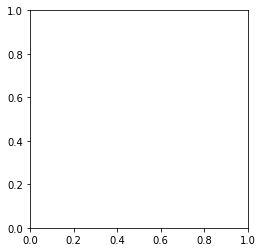

In [19]:
conv = cwt2d(grayscale_eq, 1, 1)
plt.imshow(conv, interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

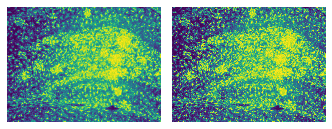

In [36]:
filtered_img = threshold_local(grayscale_eq, 13)

fig = plt.figure(figsize=(7, 2))

fig.add_subplot(1, 3, 1)
plt.imshow(filtered_img, interpolation='nearest')
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_eq, interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
https://github.com/duducosmos/kPyWavelet/blob/master/kPyWavelet/twod.py

https://scikit-image.org/docs/dev/api/skimage.filters.html
    
https://docs.astropy.org/en/stable/convolution/
    
https://pypi.org/project/pyimagej/
    https://imagej.nih.gov/ij/plugins/mexican-hat/index.html

SyntaxError: invalid syntax (<ipython-input-8-064907886777>, line 1)

In [38]:
import pywt
>>> import numpy as np
>>> import matplotlib.pyplot as plt
>>> t = np.linspace(-1, 1, 200, endpoint=False)
>>> sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
>>> widths = np.arange(1, 31)
>>> cwtmatr, freqs = pywt.cwt(grayscale_eq, widths, 'mexh')
>>> plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
...            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
>>> plt.show() # doctest: +SKIP


ValueError: Only dim == 1 supported